# An in-depth understanding of neural networks
> How does a neural network work?
- toc: true
- branch: master
- badges: true
- image: images/transformation.png
- comments: true
- author: Sajjad Ayoubi
- categories: [implementation]

In [1]:
import numpy as np
import math, random, time
from IPython import display
import matplotlib.pyplot as plt

import torch
from torch import nn

helper functions

In [2]:
def set_default(figsize=(5, 5), dpi=100):
    plt.style.use(['dark_background', 'bmh'])
    plt.rc('axes', facecolor='k')
    plt.rc('figure', facecolor='k')
    plt.rc('figure', figsize=figsize, dpi=dpi)

set_default()

def plot_data(X, y):
    X = X.cpu()
    y = y.cpu()
    plt.scatter(X.numpy()[:, 0], X.numpy()[:, 1], c=y)


def plot_model(X, y, model):
    model.cpu()
    mesh = np.arange(-1.1, 1.1, 0.01)
    xx, yy = np.meshgrid(mesh, mesh)
    with torch.no_grad():
        data = torch.from_numpy(np.vstack((xx.reshape(-1), yy.reshape(-1))).T).float()
        Z = model(data).detach()
        
    Z = np.argmax(Z, axis=1).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3)
    plot_data(X, y)

a normal distribution dataset

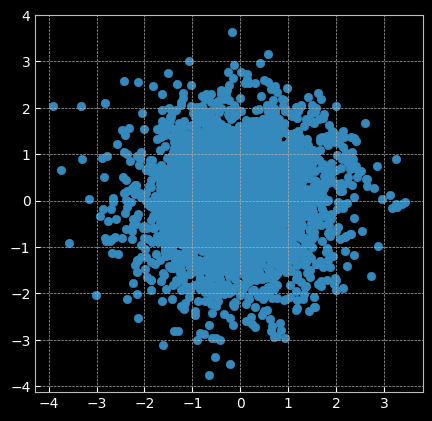

In [3]:
n_points = 3_000
X = torch.randn(n_points, 2)
plt.scatter(X[:, 0], X[:, 1]);

after applying a shear transformation with a Linear layer

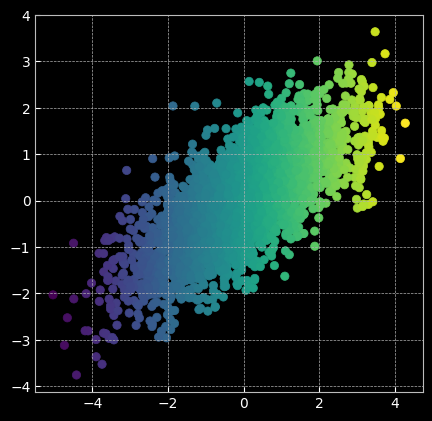

In [5]:
# a linear transformation (just from 0 to 0 without bias)
trans = nn.Linear(2, 2, bias=False)
trans.weight.data = torch.tensor([[1, 1], 
                                  [0, 1.]])

with torch.no_grad():
#     X_transfromed = X @ trans.weight 
    X_transfromed = trans(X)
    
    plt.scatter(X_transfromed[:, 0], X_transfromed[:, 1], c=X_transfromed[:, 0]);

## Classification

create a non-linear dataset for classification

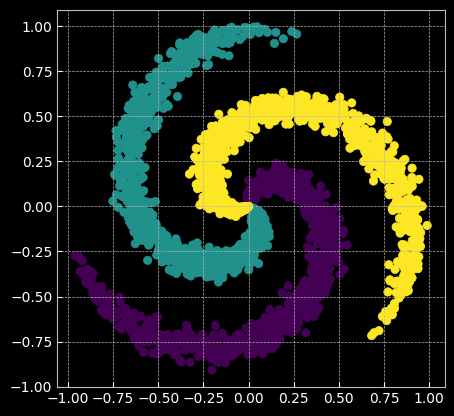

In [4]:
N = 1000  # num_samples_per_class
D = 2  # dimensions
C = 3 # num_classes
H = 100  # num_hidden_units

x = torch.zeros(N * C, D)
y = torch.zeros(N * C, dtype=torch.long)
for c in range(C):
    index = 0
    t = torch.linspace(0, 1, N)
    inner_var = torch.linspace(
        (2 * math.pi / C) * (c),
        (2 * math.pi / C) * (2 + c),
        N
    ) + torch.randn(N) * 0.2
    
    for ix in range(N * c, N * (c + 1)):
        x[ix] = t[index] * torch.FloatTensor((
            math.sin(inner_var[index]), math.cos(inner_var[index])
        ))
        y[ix] = c
        index += 1

plt.scatter(x[:, 0], x[:, 1], c=y);

create a PyTorch Trainer

In [5]:
class Tranier:
    def __init__(self, n_dim=1000, lr=1e-2, 
                 num_classes=2, input_dim=2,
                 sleep=0.1, loss_fn=nn.CrossEntropyLoss()):
        
        self.model =  nn.Sequential(nn.Linear(input_dim, n_dim), 
                                    nn.ReLU(), 
                                    nn.Linear(n_dim, num_classes))
        
        self.loss_fn = loss_fn
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)
        self.sleep = sleep
        print('number of the neurons: ', sum([i.numel() for i in self.model.parameters()]))
    
    def train_step(self, x, y, i):
        self.optimizer.zero_grad()
        y_hat = self.model(x)
        loss = self.loss_fn(y_hat, y)
        loss.backward()
        self.optimizer.step()
        # print stats
        score, predicted = torch.max(y_hat, 1)
        acc = (y == predicted).sum().float() / len(y)
        display.clear_output(wait=True)
        print("[STEP]: %i [LOSS]: %.6f, [ACCURACY]: %.3f" % (i, loss.item(), acc.item()))
        time.sleep(self.sleep)
    
        return y_hat.cpu().detach().numpy()
    
    def fit(self, x, y, steps):
        for i in range(1, steps+1):
            self.train_step(x, y, i=i)

In [158]:
learner = Tranier(n_dim=100, num_classes=3, sleep=.0)
learner.fit(x, y, steps=300)

[STEP]: 300 [LOSS]: 0.050258, [ACCURACY]: 0.997


plot decision boundaries

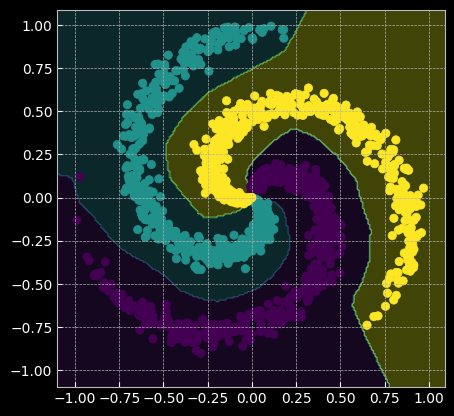

In [159]:
plot_model(x, y, learner.model)

In [15]:
class VisTrainer(Tranier):
    def fit(self, x, y, steps=5, plot_step=1):
        plt.figure(figsize=(20, 8))
        for i in range(1, steps+1):
            represent = self.train_step(x, y, i=i)
            if i%plot_step==0:
                plt.subplot(2, (steps//plot_step)//2, i//plot_step)
                plt.title(f'Training Step: {i}')
                plt.scatter(represent[:, 0], represent[:, 1], c=y)   
        plt.show()

transformations of data points during training 
- from non-linear separable to linear separable

[STEP]: 300 [LOSS]: 0.051734, [ACCURACY]: 0.997


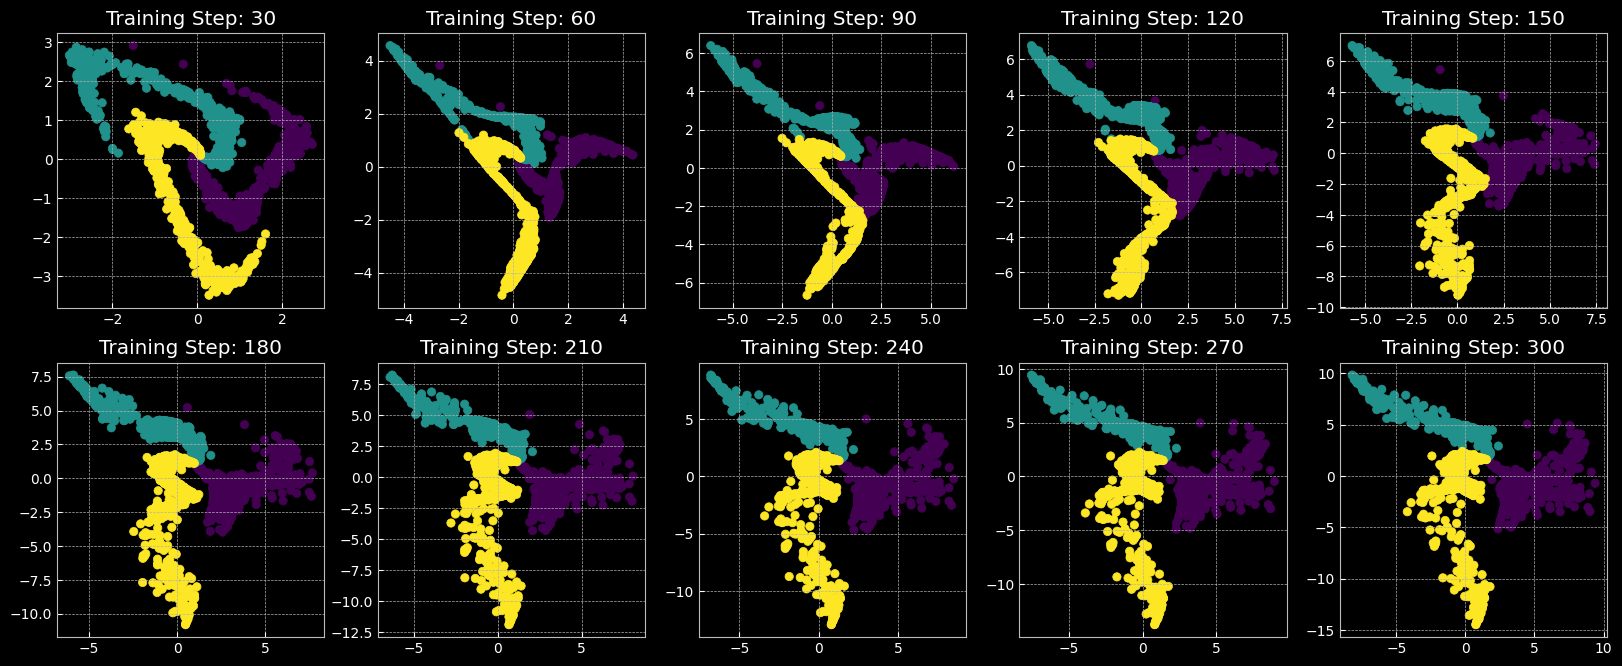

In [197]:
learner = VisTrainer(n_dim=100, num_classes=3, sleep=.0)
learner.fit(x, y, steps=300, plot_step=30)

## Regression
create a non-linear dataset for Regression

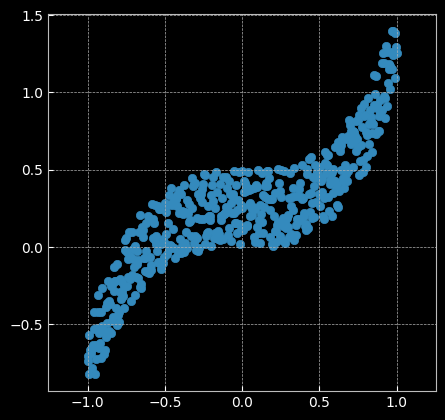

In [169]:
n_samples = 500
x = torch.unsqueeze(torch.linspace(-1, 1, n_samples), dim=1)
y = x.pow(3) + 0.5 * torch.rand(x.size())

plt.scatter(x, y)
plt.axis('equal');

In [170]:
learner = Tranier(n_dim=100, sleep=.03, input_dim=1,
                  num_classes=1, loss_fn=nn.MSELoss())

learner.fit(x, y, steps=100)

[STEP]: 100 [LOSS]: 0.020581, [ACCURACY]: 0.000


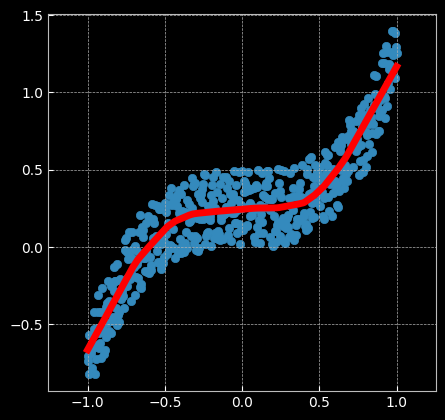

In [171]:
y_hat = learner.model(x).data.cpu().numpy()
plt.scatter(x, y)
plt.plot(x, y_hat, 'r-', lw=5)
plt.axis('equal');

In [172]:
class VisTrainer(Tranier):
    def fit(self, x, y, steps=5, plot_step=1):
        plt.figure(figsize=(20, 8))
        for i in range(1, steps+1):
            represent = self.train_step(x, y, i=i)
            if i%plot_step==0:
                plt.subplot(2, (steps//plot_step)//2, i//plot_step)
                plt.title(f'Training Step: {i}')
                plt.scatter(represent, y) # diffent from classifiaction trainer
        plt.show()

transformations of data points during training
- from non-linear to linear

[STEP]: 100 [LOSS]: 0.021687, [ACCURACY]: 0.000


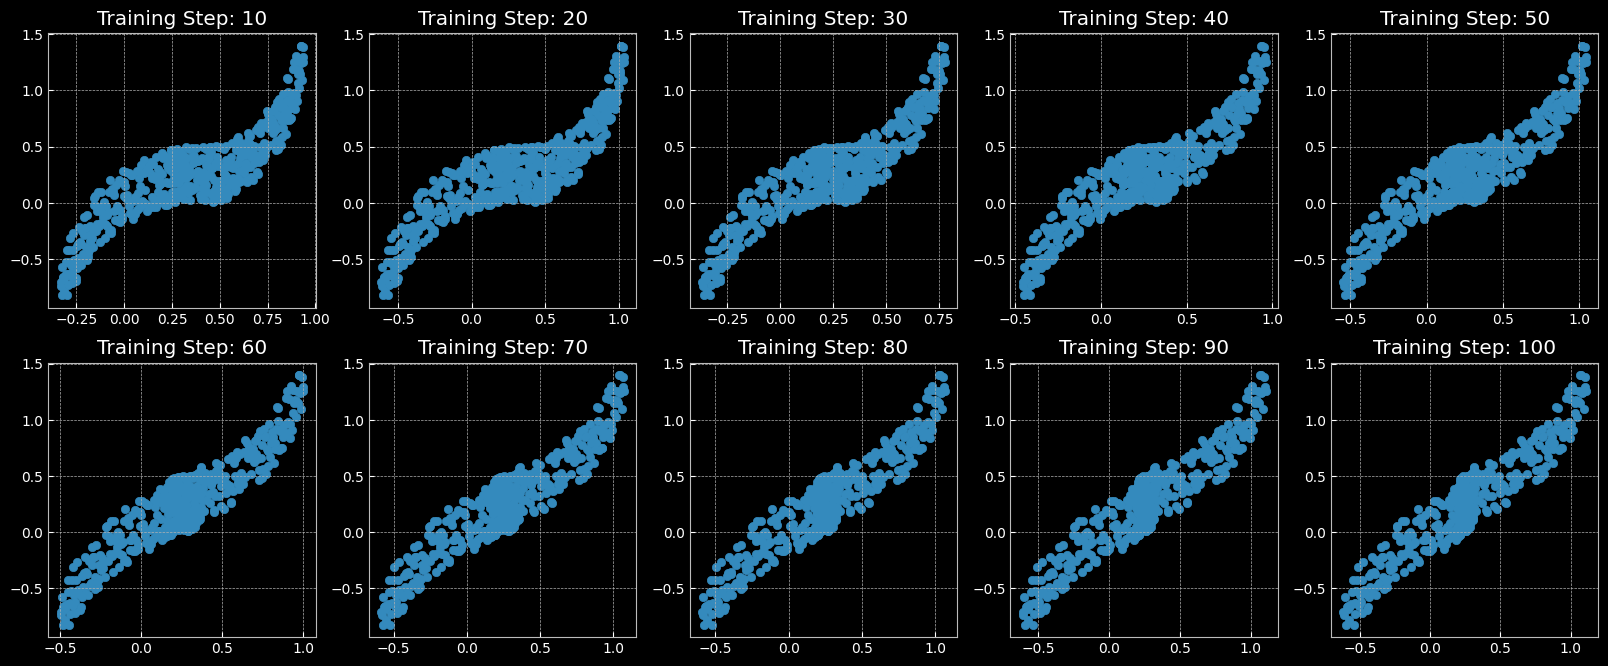

In [175]:
learner = VisTrainer(n_dim=50, sleep=.03, input_dim=1,
                     num_classes=1, loss_fn=nn.MSELoss())

learner.fit(x, y, steps=100, plot_step=10)